##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#載入該url下的壓縮檔，存入本機的'C:\Users\myComputer\.kera\dataset\flower_photos'檔案夾，並對tar檔解壓縮
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 17s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count) #影像數量
print(data_dir) #下載到你電腦裡的.keras\datasets\flower_photos 路徑

3670
C:\Users\plsun\.keras\datasets\flower_photos


Here are some roses:

[WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/10503217854_e66a804309.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/11102341464_508d558dfc_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/11233672494_d8bf0a3dbf_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/11694025703_9a906fedc1_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/118974357_0faa23cce9_n.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flower_photos/roses/11944957684_2cc806276e.jpg'), WindowsPath('C:/Users/plsun/.keras/datasets/flowe

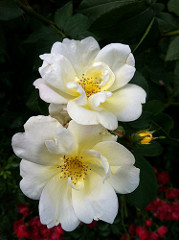

In [11]:
roses = list(data_dir.glob('roses/*')) #匯入roses檔案匣中的所有影像名稱
PIL.Image.open(str(roses[0])) #開啟第0號影像

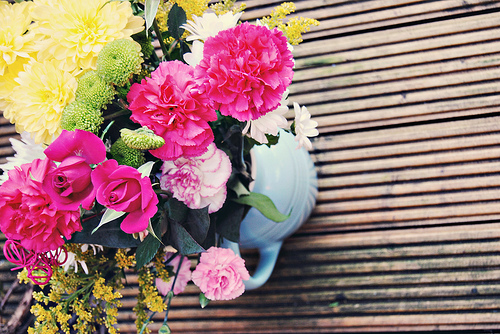

In [6]:
PIL.Image.open(str(roses[1])) #開啟第1號影像

And some tulips:

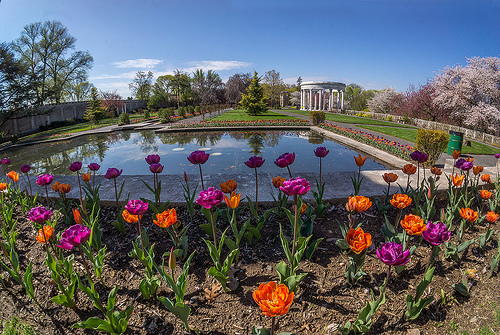

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

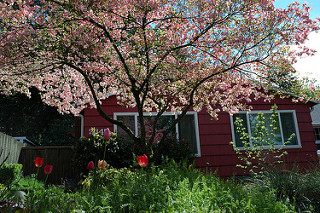

In [8]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32 #批量
img_height = 180 #輸入網路的影像高
img_width = 180 #輸入網路的影像寬

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory( #訓練集
  data_dir, #影像路徑
  validation_split=0.2, #驗證集比率：80%影像用於訓練，20%用於驗證
  subset="training", #資料集名稱
  seed=123, #種子點編號
  image_size=(img_height, img_width), #輸入網路模型的影像尺寸
  batch_size=batch_size) #批量(每次更新參數所用的影像數量)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory( #驗證集
  data_dir, #影像路徑
  validation_split=0.2, #驗證集比率：80%影像用於訓練，20%用於驗證
  subset="validation", #資料集名稱
  seed=123, #種子點編號
  image_size=(img_height, img_width), #輸入網路模型的影像尺寸
  batch_size=batch_size) #批量(每次更新參數所用的影像數量)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [15]:
class_names = train_ds.class_names #類別名稱表列
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

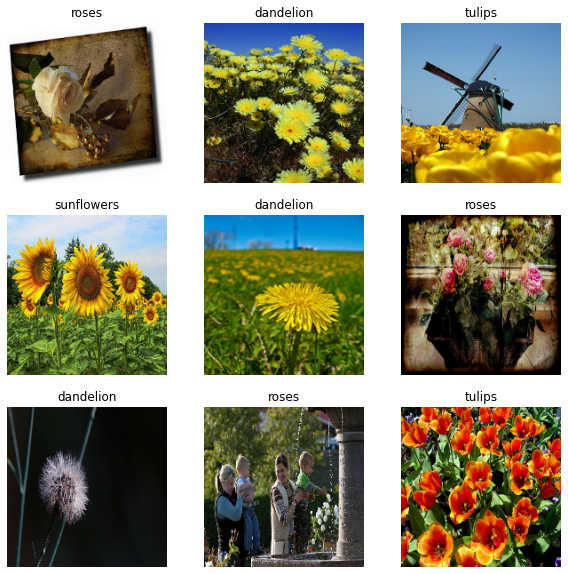

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #輸入下一批次
  for i in range(9): #前九個影像
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) #以uint8格式顯示
    plt.title(class_names[labels[i]]) #標體顯示類別名稱
    plt.axis("off") #不顯示刻度

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [16]:
for image_batch, labels_batch in train_ds: #迴圈每次讀取一批次資料，包括影像與分類標記
  print(image_batch.shape) #shape=(批量,影像高,影像寬,通道數)
  print(labels_batch.shape) #shape=(批量）
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #記憶體優化
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #記憶體優化

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)  #將影像明暗調至[0 1]範圍

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
#lambda是一個沒有名稱、沒有def的小函式。x是影像，經過[0,1]正規化，y是分類標記，不處理
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#next(iter(data))傳回一個批次的數據
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0] #這個批次的第0號影像
# 影像數據大約在[0,1]之間
print(np.min(first_image), np.max(first_image)) 

#[0,1]正規化也可以直接如下一個cell的第4行，直接在Model中設定

0.006427039 0.99052274


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
num_classes = 5 #類別總數

model = Sequential([
  #輸入彩色影像，先做[0,1]正規化，並將尺寸resize成180x180
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #2D卷積層：16種濾鏡3x3濾鏡，處理後高寬不變，以relu做激勵函數輸出
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #最大值池化層：預設pool_size=2x2
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), #平坦層：把特徵向量變成一維資料
  layers.Dense(128, activation='relu'), #全聯接層：128節點(神經原)，以relu做激勵函數輸出
  layers.Dense(num_classes) #輸出層：節點數量同類別數量
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary() #列出網路結構

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [21]:
epochs=10 #訓練資料全數使用次數
history = model.fit( #訓練過程的loss與accuracy會存在histogray中
  train_ds, #訓練集
  validation_data=val_ds, #驗證集
  epochs=epochs,
  verbose=2
)

Epoch 1/10
92/92 - 66s - loss: 1.3172 - accuracy: 0.4206 - val_loss: 1.0580 - val_accuracy: 0.5531 - 66s/epoch - 721ms/step
Epoch 2/10
92/92 - 63s - loss: 0.9724 - accuracy: 0.6219 - val_loss: 0.9521 - val_accuracy: 0.6172 - 63s/epoch - 681ms/step
Epoch 3/10
92/92 - 62s - loss: 0.7554 - accuracy: 0.7115 - val_loss: 0.8840 - val_accuracy: 0.6540 - 62s/epoch - 675ms/step
Epoch 4/10
92/92 - 65s - loss: 0.5503 - accuracy: 0.8001 - val_loss: 0.9859 - val_accuracy: 0.6131 - 65s/epoch - 712ms/step
Epoch 5/10
92/92 - 64s - loss: 0.3390 - accuracy: 0.8849 - val_loss: 1.1535 - val_accuracy: 0.6226 - 64s/epoch - 701ms/step
Epoch 6/10
92/92 - 62s - loss: 0.1808 - accuracy: 0.9441 - val_loss: 1.2761 - val_accuracy: 0.6485 - 62s/epoch - 676ms/step
Epoch 7/10
92/92 - 60s - loss: 0.1170 - accuracy: 0.9670 - val_loss: 1.4140 - val_accuracy: 0.6376 - 60s/epoch - 656ms/step
Epoch 8/10
92/92 - 58s - loss: 0.1134 - accuracy: 0.9653 - val_loss: 1.5784 - val_accuracy: 0.6185 - 58s/epoch - 628ms/step
Epoch 9/

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

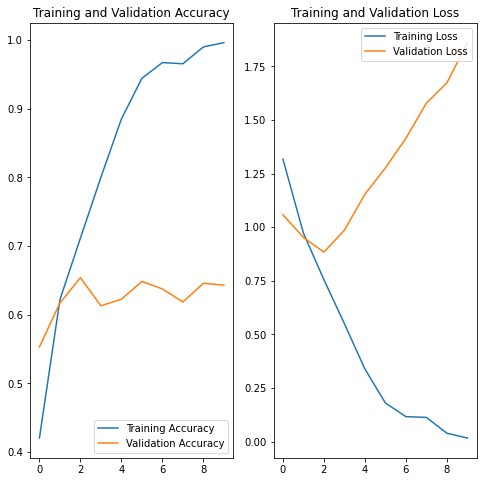

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [24]:
#設定資料擴增的函式超參數
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", #左右翻轉
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1), #旋轉
    layers.experimental.preprocessing.RandomZoom(0.1), #縮放
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

(32, 180, 180, 3)


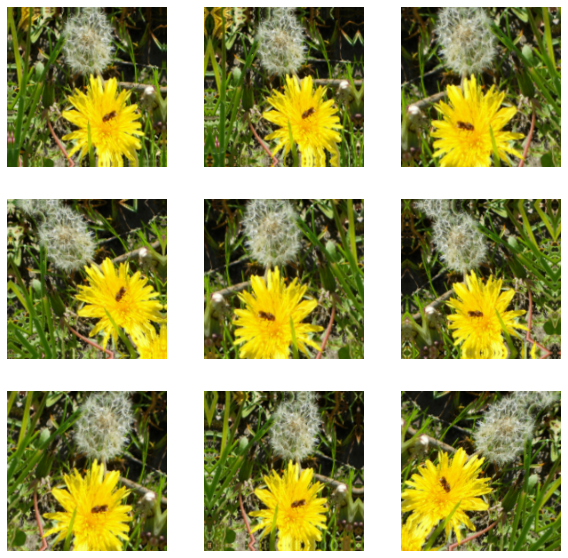

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): #抓下一批次訓練影像，不看分類標記
  print(images.shape)
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #Dropout: 隨機將20％的節點輸出設成0
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
) 

Epoch 1/15



 1/92 [..............................] - ETA: 0s - loss: 1.6229 - accuracy: 0.1562


 6/92 [>.............................] - ETA: 0s - loss: 2.5396 - accuracy: 0.2292


11/92 [==>...........................] - ETA: 0s - loss: 2.1188 - accuracy: 0.2131


16/92 [====>.........................] - ETA: 0s - loss: 1.9533 - accuracy: 0.2051


21/92 [=====>........................] - ETA: 0s - loss: 1.8606 - accuracy: 0.1935


26/92 [=======>......................] - ETA: 0s - loss: 1.7994 - accuracy: 0.2151


31/92 [=========>....................] - ETA: 0s - loss: 1.7481 - accuracy: 0.2319


36/92 [==========>...................] - ETA: 0s - loss: 1.7067 - accuracy: 0.2526


41/92 [============>.................] - ETA: 0s - loss: 1.6589 - accuracy: 0.2713


46/92 [==============>...............] - ETA: 0s - loss: 1.6256 - accuracy: 0.2826


51/92 [===============>..............] - ETA: 0s - loss: 1.5816 - accuracy: 0.3009


56/92 [=================>............] - ETA: 0s - loss: 1.5542 - accuracy: 0.3198


61/92 [==================>...........] - ETA: 0s - loss: 1.5296 - accuracy: 0.3356


66/92 [====================>.........] - ETA: 0s - loss: 1.5087 - accuracy: 0.3460


71/92 [======================>.......] - ETA: 0s - loss: 1.4889 - accuracy: 0.3542


76/92 [=======================>......] - ETA: 0s - loss: 1.4775 - accuracy: 0.3597


81/92 [=========================>....] - ETA: 0s - loss: 1.4654 - accuracy: 0.3646


86/92 [===========================>..] - ETA: 0s - loss: 1.4522 - accuracy: 0.3695


91/92 [============================>.] - ETA: 0s - loss: 1.4370 - accuracy: 0.3740


92/92 [==============================] - 1s 13ms/step - loss: 1.4326 - accuracy: 0.3760 - val_loss: 1.1774 - val_accuracy: 0.5123


Epoch 2/15

 1/92 [..............................] - ETA: 0s - loss: 1.0562 - accuracy: 0.7083


 6/92 [>.............................] - ETA: 0s - loss: 1.2888 - accuracy: 0.5163


11/92 [==>...........................] - ETA: 0s - loss: 1.3020 - accuracy: 0.4622


16/92 [====>.........................] - ETA: 0s - loss: 1.2193 - accuracy: 0.5040


21/92 [=====>........................] - ETA: 0s - loss: 1.2059 - accuracy: 0.5045


26/92 [=======>......................] - ETA: 0s - loss: 1.1917 - accuracy: 0.5097


31/92 [=========>....................] - ETA: 0s - loss: 1.1851 - accuracy: 0.5102


36/92 [==========>...................] - ETA: 0s - loss: 1.1735 - accuracy: 0.5175


41/92 [============>.................] - ETA: 0s - loss: 1.1816 - accuracy: 0.5192


46/92 [==============>...............] - ETA: 0s - loss: 1.1704 - accuracy: 0.5280


51/92 [===============>..............] - ETA: 0s - loss: 1.1621 - accuracy: 0.5308


56/92 [=================>............] - ETA: 0s - loss: 1.1596 - accuracy: 0.5303


61/92 [==================>...........] - ETA: 0s - loss: 1.1408 - accuracy: 0.5345


66/92 [====================>.........] - ETA: 0s - loss: 1.1336 - accuracy: 0.5404


71/92 [======================>.......] - ETA: 0s - loss: 1.1279 - accuracy: 0.5451


76/92 [=======================>......] - ETA: 0s - loss: 1.1232 - accuracy: 0.5450


81/92 [=========================>....] - ETA: 0s - loss: 1.1162 - accuracy: 0.5488


86/92 [===========================>..] - ETA: 0s - loss: 1.1128 - accuracy: 0.5492


91/92 [============================>.] - ETA: 0s - loss: 1.1078 - accuracy: 0.5523


92/92 [==============================] - 1s 12ms/step - loss: 1.1058 - accuracy: 0.5525 - val_loss: 0.9981 - val_accuracy: 0.5967


Epoch 3/15

 1/92 [..............................] - ETA: 0s - loss: 1.0219 - accuracy: 0.6562


 6/92 [>.............................] - ETA: 0s - loss: 1.0862 - accuracy: 0.5729


11/92 [==>...........................] - ETA: 0s - loss: 1.0380 - accuracy: 0.6051


16/92 [====>.........................] - ETA: 0s - loss: 1.0310 - accuracy: 0.6074


21/92 [=====>........................] - ETA: 0s - loss: 1.0122 - accuracy: 0.6146


26/92 [=======>......................] - ETA: 0s - loss: 0.9923 - accuracy: 0.6274


31/92 [=========>....................] - ETA: 0s - loss: 0.9888 - accuracy: 0.6230


36/92 [==========>...................] - ETA: 0s - loss: 0.9924 - accuracy: 0.6094


41/92 [============>.................] - ETA: 0s - loss: 0.9965 - accuracy: 0.6052


46/92 [==============>...............] - ETA: 0s - loss: 0.9998 - accuracy: 0.6046


51/92 [===============>..............] - ETA: 0s - loss: 1.0049 - accuracy: 0.6022


56/92 [=================>............] - ETA: 0s - loss: 1.0061 - accuracy: 0.6003


61/92 [==================>...........] - ETA: 0s - loss: 1.0063 - accuracy: 0.5988


66/92 [====================>.........] - ETA: 0s - loss: 0.9990 - accuracy: 0.5970


71/92 [======================>.......] - ETA: 0s - loss: 1.0026 - accuracy: 0.5972


76/92 [=======================>......] - ETA: 0s - loss: 1.0001 - accuracy: 0.5965


81/92 [=========================>....] - ETA: 0s - loss: 1.0024 - accuracy: 0.5956


86/92 [===========================>..] - ETA: 0s - loss: 1.0063 - accuracy: 0.5929


91/92 [============================>.] - ETA: 0s - loss: 1.0012 - accuracy: 0.5940


92/92 [==============================] - 1s 12ms/step - loss: 1.0014 - accuracy: 0.5937 - val_loss: 0.9525 - val_accuracy: 0.6185


Epoch 4/15

 1/92 [..............................] - ETA: 0s - loss: 0.8159 - accuracy: 0.6875


 6/92 [>.............................] - ETA: 0s - loss: 0.9169 - accuracy: 0.6562


11/92 [==>...........................] - ETA: 0s - loss: 0.9011 - accuracy: 0.6477


16/92 [====>.........................] - ETA: 0s - loss: 0.9202 - accuracy: 0.6172


21/92 [=====>........................] - ETA: 0s - loss: 0.9075 - accuracy: 0.6354


26/92 [=======>......................] - ETA: 0s - loss: 0.9078 - accuracy: 0.6442


31/92 [=========>....................] - ETA: 0s - loss: 0.9215 - accuracy: 0.6472


36/92 [==========>...................] - ETA: 0s - loss: 0.9302 - accuracy: 0.6380


41/92 [============>.................] - ETA: 0s - loss: 0.9281 - accuracy: 0.6334


46/92 [==============>...............] - ETA: 0s - loss: 0.9169 - accuracy: 0.6365


51/92 [===============>..............] - ETA: 0s - loss: 0.9268 - accuracy: 0.6336


56/92 [=================>............] - ETA: 0s - loss: 0.9220 - accuracy: 0.6334


61/92 [==================>...........] - ETA: 0s - loss: 0.9165 - accuracy: 0.6363


66/92 [====================>.........] - ETA: 0s - loss: 0.9126 - accuracy: 0.6364


71/92 [======================>.......] - ETA: 0s - loss: 0.9133 - accuracy: 0.6378


76/92 [=======================>......] - ETA: 0s - loss: 0.9167 - accuracy: 0.6366


81/92 [=========================>....] - ETA: 0s - loss: 0.9156 - accuracy: 0.6389


86/92 [===========================>..] - ETA: 0s - loss: 0.9219 - accuracy: 0.6345


91/92 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.6377


92/92 [==============================] - 1s 12ms/step - loss: 0.9205 - accuracy: 0.6383 - val_loss: 0.9474 - val_accuracy: 0.6376


Epoch 5/15

 1/92 [..............................] - ETA: 0s - loss: 0.6973 - accuracy: 0.6875


 6/92 [>.............................] - ETA: 0s - loss: 0.8195 - accuracy: 0.6927


11/92 [==>...........................] - ETA: 0s - loss: 0.8737 - accuracy: 0.6847


16/92 [====>.........................] - ETA: 0s - loss: 0.8752 - accuracy: 0.6699


21/92 [=====>........................] - ETA: 0s - loss: 0.8912 - accuracy: 0.6577


26/92 [=======>......................] - ETA: 0s - loss: 0.8987 - accuracy: 0.6562


31/92 [=========>....................] - ETA: 0s - loss: 0.9041 - accuracy: 0.6552


36/92 [==========>...................] - ETA: 0s - loss: 0.8923 - accuracy: 0.6510


41/92 [============>.................] - ETA: 0s - loss: 0.8859 - accuracy: 0.6547


46/92 [==============>...............] - ETA: 0s - loss: 0.8740 - accuracy: 0.6596


51/92 [===============>..............] - ETA: 0s - loss: 0.8785 - accuracy: 0.6581


56/92 [=================>............] - ETA: 0s - loss: 0.8835 - accuracy: 0.6579


61/92 [==================>...........] - ETA: 0s - loss: 0.8873 - accuracy: 0.6552


66/92 [====================>.........] - ETA: 0s - loss: 0.8827 - accuracy: 0.6558


71/92 [======================>.......] - ETA: 0s - loss: 0.8886 - accuracy: 0.6577


76/92 [=======================>......] - ETA: 0s - loss: 0.8849 - accuracy: 0.6576


81/92 [=========================>....] - ETA: 0s - loss: 0.8777 - accuracy: 0.6602


86/92 [===========================>..] - ETA: 0s - loss: 0.8740 - accuracy: 0.6600


91/92 [============================>.] - ETA: 0s - loss: 0.8816 - accuracy: 0.6584


92/92 [==============================] - 1s 12ms/step - loss: 0.8813 - accuracy: 0.6594 - val_loss: 0.9383 - val_accuracy: 0.6417


Epoch 6/15

 1/92 [..............................] - ETA: 0s - loss: 0.7770 - accuracy: 0.6875


 6/92 [>.............................] - ETA: 0s - loss: 0.8446 - accuracy: 0.6667


11/92 [==>...........................] - ETA: 0s - loss: 0.8395 - accuracy: 0.6761


16/92 [====>.........................] - ETA: 0s - loss: 0.8471 - accuracy: 0.6816


21/92 [=====>........................] - ETA: 0s - loss: 0.8351 - accuracy: 0.6845


26/92 [=======>......................] - ETA: 0s - loss: 0.8140 - accuracy: 0.6863


31/92 [=========>....................] - ETA: 0s - loss: 0.8372 - accuracy: 0.6825


36/92 [==========>...................] - ETA: 0s - loss: 0.8424 - accuracy: 0.6788


41/92 [============>.................] - ETA: 0s - loss: 0.8455 - accuracy: 0.6738


46/92 [==============>...............] - ETA: 0s - loss: 0.8490 - accuracy: 0.6714


51/92 [===============>..............] - ETA: 0s - loss: 0.8466 - accuracy: 0.6675


56/92 [=================>............] - ETA: 0s - loss: 0.8343 - accuracy: 0.6732


61/92 [==================>...........] - ETA: 0s - loss: 0.8333 - accuracy: 0.6728


66/92 [====================>.........] - ETA: 0s - loss: 0.8255 - accuracy: 0.6759


71/92 [======================>.......] - ETA: 0s - loss: 0.8327 - accuracy: 0.6762


76/92 [=======================>......] - ETA: 0s - loss: 0.8355 - accuracy: 0.6745


81/92 [=========================>....] - ETA: 0s - loss: 0.8415 - accuracy: 0.6722


86/92 [===========================>..] - ETA: 0s - loss: 0.8388 - accuracy: 0.6738


91/92 [============================>.] - ETA: 0s - loss: 0.8396 - accuracy: 0.6722


92/92 [==============================] - 1s 12ms/step - loss: 0.8366 - accuracy: 0.6734 - val_loss: 0.8468 - val_accuracy: 0.6512


Epoch 7/15

 1/92 [..............................] - ETA: 0s - loss: 0.9035 - accuracy: 0.6250


 6/92 [>.............................] - ETA: 0s - loss: 0.7428 - accuracy: 0.6927


11/92 [==>...........................] - ETA: 0s - loss: 0.7204 - accuracy: 0.7216


16/92 [====>.........................] - ETA: 0s - loss: 0.7865 - accuracy: 0.7090


21/92 [=====>........................] - ETA: 0s - loss: 0.7953 - accuracy: 0.6964


26/92 [=======>......................] - ETA: 0s - loss: 0.7927 - accuracy: 0.6947


31/92 [=========>....................] - ETA: 0s - loss: 0.7849 - accuracy: 0.6996


36/92 [==========>...................] - ETA: 0s - loss: 0.7814 - accuracy: 0.7005


41/92 [============>.................] - ETA: 0s - loss: 0.7870 - accuracy: 0.6966


46/92 [==============>...............] - ETA: 0s - loss: 0.7877 - accuracy: 0.6990


51/92 [===============>..............] - ETA: 0s - loss: 0.7806 - accuracy: 0.7016


56/92 [=================>............] - ETA: 0s - loss: 0.7968 - accuracy: 0.6936


61/92 [==================>...........] - ETA: 0s - loss: 0.7969 - accuracy: 0.6939


66/92 [====================>.........] - ETA: 0s - loss: 0.7986 - accuracy: 0.6953


71/92 [======================>.......] - ETA: 0s - loss: 0.8005 - accuracy: 0.6961


76/92 [=======================>......] - ETA: 0s - loss: 0.7938 - accuracy: 0.7005


81/92 [=========================>....] - ETA: 0s - loss: 0.8029 - accuracy: 0.6943


86/92 [===========================>..] - ETA: 0s - loss: 0.8038 - accuracy: 0.6950


91/92 [============================>.] - ETA: 0s - loss: 0.7939 - accuracy: 0.6987


92/92 [==============================] - 1s 12ms/step - loss: 0.7955 - accuracy: 0.6979 - val_loss: 0.8837 - val_accuracy: 0.6717


Epoch 8/15

 1/92 [..............................] - ETA: 0s - loss: 0.5759 - accuracy: 0.7500


 6/92 [>.............................] - ETA: 0s - loss: 0.6974 - accuracy: 0.7292


11/92 [==>...........................] - ETA: 0s - loss: 0.7498 - accuracy: 0.7102


16/92 [====>.........................] - ETA: 0s - loss: 0.7582 - accuracy: 0.7012


21/92 [=====>........................] - ETA: 0s - loss: 0.7645 - accuracy: 0.6979


26/92 [=======>......................] - ETA: 0s - loss: 0.7723 - accuracy: 0.6983


31/92 [=========>....................] - ETA: 0s - loss: 0.7550 - accuracy: 0.7087


36/92 [==========>...................] - ETA: 0s - loss: 0.7473 - accuracy: 0.7107


41/92 [============>.................] - ETA: 0s - loss: 0.7441 - accuracy: 0.7178


46/92 [==============>...............] - ETA: 0s - loss: 0.7481 - accuracy: 0.7199


51/92 [===============>..............] - ETA: 0s - loss: 0.7510 - accuracy: 0.7235


56/92 [=================>............] - ETA: 0s - loss: 0.7426 - accuracy: 0.7231


61/92 [==================>...........] - ETA: 0s - loss: 0.7409 - accuracy: 0.7258


66/92 [====================>.........] - ETA: 0s - loss: 0.7360 - accuracy: 0.7253


71/92 [======================>.......] - ETA: 0s - loss: 0.7413 - accuracy: 0.7213


76/92 [=======================>......] - ETA: 0s - loss: 0.7496 - accuracy: 0.7174


81/92 [=========================>....] - ETA: 0s - loss: 0.7477 - accuracy: 0.7167


86/92 [===========================>..] - ETA: 0s - loss: 0.7437 - accuracy: 0.7172


91/92 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.7169


92/92 [==============================] - 1s 12ms/step - loss: 0.7485 - accuracy: 0.7163 - val_loss: 0.8417 - val_accuracy: 0.6730


Epoch 9/15

 1/92 [..............................] - ETA: 0s - loss: 0.7650 - accuracy: 0.6250


 6/92 [>.............................] - ETA: 0s - loss: 0.7005 - accuracy: 0.7292


11/92 [==>...........................] - ETA: 0s - loss: 0.6745 - accuracy: 0.7614


16/92 [====>.........................] - ETA: 0s - loss: 0.6893 - accuracy: 0.7578


21/92 [=====>........................] - ETA: 0s - loss: 0.6863 - accuracy: 0.7589


26/92 [=======>......................] - ETA: 0s - loss: 0.7185 - accuracy: 0.7416


31/92 [=========>....................] - ETA: 0s - loss: 0.7190 - accuracy: 0.7379


36/92 [==========>...................] - ETA: 0s - loss: 0.7214 - accuracy: 0.7378


41/92 [============>.................] - ETA: 0s - loss: 0.7218 - accuracy: 0.7355


46/92 [==============>...............] - ETA: 0s - loss: 0.7280 - accuracy: 0.7295


51/92 [===============>..............] - ETA: 0s - loss: 0.7285 - accuracy: 0.7303


56/92 [=================>............] - ETA: 0s - loss: 0.7344 - accuracy: 0.7276


61/92 [==================>...........] - ETA: 0s - loss: 0.7239 - accuracy: 0.7310


66/92 [====================>.........] - ETA: 0s - loss: 0.7151 - accuracy: 0.7362


71/92 [======================>.......] - ETA: 0s - loss: 0.7226 - accuracy: 0.7354


76/92 [=======================>......] - ETA: 0s - loss: 0.7313 - accuracy: 0.7298


81/92 [=========================>....] - ETA: 0s - loss: 0.7294 - accuracy: 0.7279


86/92 [===========================>..] - ETA: 0s - loss: 0.7324 - accuracy: 0.7274


91/92 [============================>.] - ETA: 0s - loss: 0.7285 - accuracy: 0.7283


92/92 [==============================] - 1s 12ms/step - loss: 0.7276 - accuracy: 0.7282 - val_loss: 0.8505 - val_accuracy: 0.6826


Epoch 10/15

 1/92 [..............................] - ETA: 0s - loss: 0.6783 - accuracy: 0.6562


 6/92 [>.............................] - ETA: 0s - loss: 0.6051 - accuracy: 0.7552


11/92 [==>...........................] - ETA: 0s - loss: 0.6352 - accuracy: 0.7528


16/92 [====>.........................] - ETA: 0s - loss: 0.6247 - accuracy: 0.7617


21/92 [=====>........................] - ETA: 0s - loss: 0.6630 - accuracy: 0.7560


26/92 [=======>......................] - ETA: 0s - loss: 0.6589 - accuracy: 0.7632


31/92 [=========>....................] - ETA: 0s - loss: 0.6689 - accuracy: 0.7621


36/92 [==========>...................] - ETA: 0s - loss: 0.6768 - accuracy: 0.7578


41/92 [============>.................] - ETA: 0s - loss: 0.6910 - accuracy: 0.7485


46/92 [==============>...............] - ETA: 0s - loss: 0.6942 - accuracy: 0.7446


51/92 [===============>..............] - ETA: 0s - loss: 0.6842 - accuracy: 0.7506


56/92 [=================>............] - ETA: 0s - loss: 0.6822 - accuracy: 0.7506


61/92 [==================>...........] - ETA: 0s - loss: 0.6883 - accuracy: 0.7464


66/92 [====================>.........] - ETA: 0s - loss: 0.6848 - accuracy: 0.7424


71/92 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.7394


76/92 [=======================>......] - ETA: 0s - loss: 0.6957 - accuracy: 0.7364


81/92 [=========================>....] - ETA: 0s - loss: 0.6979 - accuracy: 0.7368


86/92 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.7402


91/92 [============================>.] - ETA: 0s - loss: 0.6989 - accuracy: 0.7373


92/92 [==============================] - 1s 12ms/step - loss: 0.6981 - accuracy: 0.7374 - val_loss: 0.7679 - val_accuracy: 0.6948


Epoch 11/15

 1/92 [..............................] - ETA: 0s - loss: 0.6801 - accuracy: 0.7812


 6/92 [>.............................] - ETA: 0s - loss: 0.5706 - accuracy: 0.8125


11/92 [==>...........................] - ETA: 0s - loss: 0.5835 - accuracy: 0.7983


16/92 [====>.........................] - ETA: 0s - loss: 0.6042 - accuracy: 0.7891


21/92 [=====>........................] - ETA: 0s - loss: 0.6117 - accuracy: 0.7812


26/92 [=======>......................] - ETA: 0s - loss: 0.6160 - accuracy: 0.7767


31/92 [=========>....................] - ETA: 0s - loss: 0.6382 - accuracy: 0.7673


36/92 [==========>...................] - ETA: 0s - loss: 0.6508 - accuracy: 0.7622


41/92 [============>.................] - ETA: 0s - loss: 0.6672 - accuracy: 0.7515


46/92 [==============>...............] - ETA: 0s - loss: 0.6644 - accuracy: 0.7507


51/92 [===============>..............] - ETA: 0s - loss: 0.6604 - accuracy: 0.7494


56/92 [=================>............] - ETA: 0s - loss: 0.6631 - accuracy: 0.7478


61/92 [==================>...........] - ETA: 0s - loss: 0.6508 - accuracy: 0.7536


66/92 [====================>.........] - ETA: 0s - loss: 0.6507 - accuracy: 0.7529


71/92 [======================>.......] - ETA: 0s - loss: 0.6565 - accuracy: 0.7522


76/92 [=======================>......] - ETA: 0s - loss: 0.6559 - accuracy: 0.7537


81/92 [=========================>....] - ETA: 0s - loss: 0.6607 - accuracy: 0.7523


86/92 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.7482


91/92 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.7452


92/92 [==============================] - 1s 12ms/step - loss: 0.6755 - accuracy: 0.7446 - val_loss: 0.7863 - val_accuracy: 0.6948


Epoch 12/15

 1/92 [..............................] - ETA: 0s - loss: 0.5050 - accuracy: 0.8438


 6/92 [>.............................] - ETA: 0s - loss: 0.5999 - accuracy: 0.7552


11/92 [==>...........................] - ETA: 0s - loss: 0.6215 - accuracy: 0.7500


16/92 [====>.........................] - ETA: 0s - loss: 0.6508 - accuracy: 0.7302


21/92 [=====>........................] - ETA: 0s - loss: 0.6535 - accuracy: 0.7440


26/92 [=======>......................] - ETA: 0s - loss: 0.6359 - accuracy: 0.7524


31/92 [=========>....................] - ETA: 0s - loss: 0.6280 - accuracy: 0.7591


36/92 [==========>...................] - ETA: 0s - loss: 0.6456 - accuracy: 0.7509


41/92 [============>.................] - ETA: 0s - loss: 0.6456 - accuracy: 0.7515


46/92 [==============>...............] - ETA: 0s - loss: 0.6392 - accuracy: 0.7541


51/92 [===============>..............] - ETA: 0s - loss: 0.6499 - accuracy: 0.7512


56/92 [=================>............] - ETA: 0s - loss: 0.6437 - accuracy: 0.7550


61/92 [==================>...........] - ETA: 0s - loss: 0.6362 - accuracy: 0.7567


66/92 [====================>.........] - ETA: 0s - loss: 0.6415 - accuracy: 0.7552


71/92 [======================>.......] - ETA: 0s - loss: 0.6426 - accuracy: 0.7575


76/92 [=======================>......] - ETA: 0s - loss: 0.6424 - accuracy: 0.7562


81/92 [=========================>....] - ETA: 0s - loss: 0.6425 - accuracy: 0.7558


86/92 [===========================>..] - ETA: 0s - loss: 0.6423 - accuracy: 0.7558


91/92 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.7576


92/92 [==============================] - 1s 12ms/step - loss: 0.6375 - accuracy: 0.7585 - val_loss: 0.7911 - val_accuracy: 0.7044


Epoch 13/15

 1/92 [..............................] - ETA: 0s - loss: 0.4555 - accuracy: 0.9375


 6/92 [>.............................] - ETA: 0s - loss: 0.6498 - accuracy: 0.7656


11/92 [==>...........................] - ETA: 0s - loss: 0.6324 - accuracy: 0.7727


16/92 [====>.........................] - ETA: 0s - loss: 0.6232 - accuracy: 0.7832


21/92 [=====>........................] - ETA: 0s - loss: 0.6080 - accuracy: 0.7827


26/92 [=======>......................] - ETA: 0s - loss: 0.6093 - accuracy: 0.7800


31/92 [=========>....................] - ETA: 0s - loss: 0.5948 - accuracy: 0.7883


36/92 [==========>...................] - ETA: 0s - loss: 0.5984 - accuracy: 0.7847


41/92 [============>.................] - ETA: 0s - loss: 0.5948 - accuracy: 0.7851


46/92 [==============>...............] - ETA: 0s - loss: 0.5897 - accuracy: 0.7874


51/92 [===============>..............] - ETA: 0s - loss: 0.5897 - accuracy: 0.7892


56/92 [=================>............] - ETA: 0s - loss: 0.5989 - accuracy: 0.7840


61/92 [==================>...........] - ETA: 0s - loss: 0.6109 - accuracy: 0.7798


66/92 [====================>.........] - ETA: 0s - loss: 0.6137 - accuracy: 0.7766


71/92 [======================>.......] - ETA: 0s - loss: 0.6145 - accuracy: 0.7769


76/92 [=======================>......] - ETA: 0s - loss: 0.6179 - accuracy: 0.7752


81/92 [=========================>....] - ETA: 0s - loss: 0.6220 - accuracy: 0.7740


86/92 [===========================>..] - ETA: 0s - loss: 0.6124 - accuracy: 0.7773


91/92 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.7775


92/92 [==============================] - 1s 12ms/step - loss: 0.6095 - accuracy: 0.7790 - val_loss: 0.7403 - val_accuracy: 0.7139


Epoch 14/15

 1/92 [..............................] - ETA: 0s - loss: 0.5986 - accuracy: 0.7083


 6/92 [>.............................] - ETA: 0s - loss: 0.5309 - accuracy: 0.7826


11/92 [==>...........................] - ETA: 0s - loss: 0.5356 - accuracy: 0.7994


16/92 [====>.........................] - ETA: 0s - loss: 0.5614 - accuracy: 0.7857


21/92 [=====>........................] - ETA: 0s - loss: 0.5672 - accuracy: 0.7861


26/92 [=======>......................] - ETA: 0s - loss: 0.5793 - accuracy: 0.7803


31/92 [=========>....................] - ETA: 0s - loss: 0.5769 - accuracy: 0.7846


36/92 [==========>...................] - ETA: 0s - loss: 0.6008 - accuracy: 0.7753


41/92 [============>.................] - ETA: 0s - loss: 0.6062 - accuracy: 0.7745


46/92 [==============>...............] - ETA: 0s - loss: 0.6050 - accuracy: 0.7753


51/92 [===============>..............] - ETA: 0s - loss: 0.5972 - accuracy: 0.7777


56/92 [=================>............] - ETA: 0s - loss: 0.6003 - accuracy: 0.7741


61/92 [==================>...........] - ETA: 0s - loss: 0.6116 - accuracy: 0.7695


66/92 [====================>.........] - ETA: 0s - loss: 0.6105 - accuracy: 0.7690


71/92 [======================>.......] - ETA: 0s - loss: 0.6131 - accuracy: 0.7672


76/92 [=======================>......] - ETA: 0s - loss: 0.6187 - accuracy: 0.7657


81/92 [=========================>....] - ETA: 0s - loss: 0.6205 - accuracy: 0.7655


86/92 [===========================>..] - ETA: 0s - loss: 0.6198 - accuracy: 0.7653


91/92 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.7669


92/92 [==============================] - 1s 12ms/step - loss: 0.6116 - accuracy: 0.7681 - val_loss: 0.7794 - val_accuracy: 0.7153


Epoch 15/15

 1/92 [..............................] - ETA: 0s - loss: 0.4335 - accuracy: 0.8750


 6/92 [>.............................] - ETA: 0s - loss: 0.5499 - accuracy: 0.7865


11/92 [==>...........................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7841


16/92 [====>.........................] - ETA: 0s - loss: 0.5681 - accuracy: 0.7734


21/92 [=====>........................] - ETA: 0s - loss: 0.5538 - accuracy: 0.7857


26/92 [=======>......................] - ETA: 0s - loss: 0.5624 - accuracy: 0.7873


31/92 [=========>....................] - ETA: 0s - loss: 0.5587 - accuracy: 0.7863


36/92 [==========>...................] - ETA: 0s - loss: 0.5592 - accuracy: 0.7812


41/92 [============>.................] - ETA: 0s - loss: 0.5689 - accuracy: 0.7759


46/92 [==============>...............] - ETA: 0s - loss: 0.5603 - accuracy: 0.7801


51/92 [===============>..............] - ETA: 0s - loss: 0.5633 - accuracy: 0.7814


56/92 [=================>............] - ETA: 0s - loss: 0.5658 - accuracy: 0.7803


61/92 [==================>...........] - ETA: 0s - loss: 0.5689 - accuracy: 0.7803


66/92 [====================>.........] - ETA: 0s - loss: 0.5768 - accuracy: 0.7776


71/92 [======================>.......] - ETA: 0s - loss: 0.5798 - accuracy: 0.7769


76/92 [=======================>......] - ETA: 0s - loss: 0.5778 - accuracy: 0.7748


81/92 [=========================>....] - ETA: 0s - loss: 0.5809 - accuracy: 0.7744


86/92 [===========================>..] - ETA: 0s - loss: 0.5804 - accuracy: 0.7755


91/92 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7755


92/92 [==============================] - 1s 12ms/step - loss: 0.5818 - accuracy: 0.7762 - val_loss: 0.7729 - val_accuracy: 0.7044


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

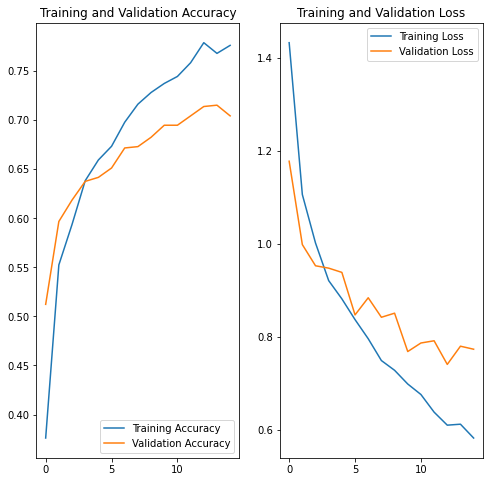

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


122880/117948 [===============================] - 0s 0us/step


This image most likely belongs to sunflowers with a 99.45 percent confidence.
